In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### import dataset used for easy tasks

In [2]:
from datasets import load_dataset

dataset = load_dataset("roszcz/internship-midi-data-science", split="train")

Found cached dataset parquet (C:/Users/samue/.cache/huggingface/datasets/roszcz___parquet/roszcz--internship-midi-data-science-5506ea35081b41a4/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


checking the format suggested on github:

In [3]:
record = dataset[0]
df = pd.DataFrame(record["notes"])
print(df.head(10))

        end  pitch     start  velocity
0  2.058438     42  1.934219        74
1  2.990469     66  1.935573        84
2  2.044531     30  1.948229        76
3  2.613073     49  2.556146        77
4  2.618333     54  2.564844        59
5  2.639687     57  2.574219        49
6  2.774792     54  2.696875        59
7  2.764375     49  2.700208        64
8  2.775677     57  2.710885        65
9  2.920833     54  2.835521        89


# Speed

We'll first check how long is the recording and utilize that counting the number of bins for the plot as well as determining the unit of time used.

In [4]:
def recordLength(record):
    return max(record["notes"]["end"]) - min(record["notes"]["start"])

In [5]:
def binSize_unit(record):
    if recordLength(record) > 120:
        return (60, "minutes")
    else:
        return (1, "seconds")

This piece of code is used to group and count the number of notes played in each bin. (60 seconds for recordings longer than 2 minutes, 1 second otherwise)

In [6]:
def binned_number_of_notes(record, binSizeOverride=None):
    binSize, unit = binSize_unit(record)
    if binSizeOverride is not None:
        binSize = binSizeOverride
        unit = "custom"
    
    recordDF = pd.DataFrame(record["notes"])

    bins = range(recordDF["start"].min().astype(int), recordDF["end"].max().astype(int), binSize)
    notes = recordDF.groupby(pd.cut(recordDF["start"], bins=bins))["velocity"].count().reset_index(name="count")

    notes.start = np.arange(1, len(notes) + 1)
    notes.columns = [unit, "notes"]

    return notes, unit, binSize


In [7]:
def plotRecord(record):
    notes, unit, binSize = binned_number_of_notes(record)
    plt.plot(notes[unit], notes["notes"]/binSize)
    plt.xlabel(unit)
    plt.ylabel("Notes per Second")
    plt.title("Speed vs Time")
    plt.show()

In [8]:
def plotAllRecords(dataset):
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))

    # add background color to the figure
    fig.patch.set_facecolor('white')
    
    for i, record in enumerate(dataset):
        notes, unit, binSize = binned_number_of_notes(record)
        axs[i//3, i%3].plot(notes[unit], notes["notes"]/binSize)
        axs[i//3, i%3].set_xlabel(unit)
        axs[i//3, i%3].set_ylabel("Notes per Second")
        axs[i//3, i%3].set_title("Speed vs Time for record " + str(record["record_id"]))
    plt.show()

I've decided to plot all 6 of the recordings in the training set to see if there are any differences between them.

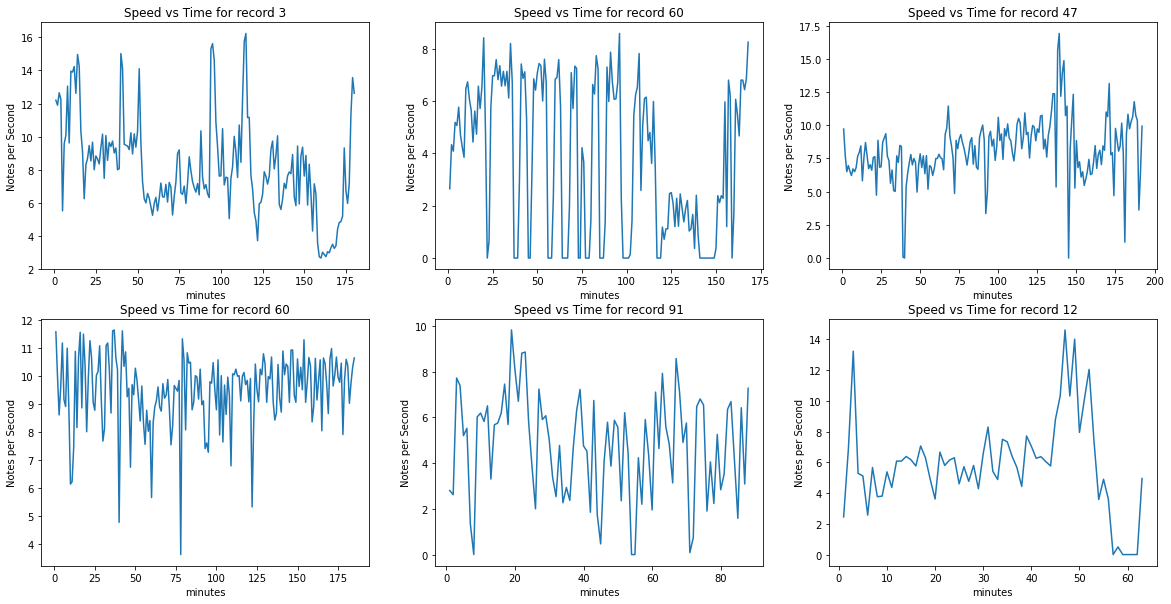

In [9]:
plotAllRecords(dataset)

## notes pressed at the same time

In [19]:
def simultaneousNotes(record, threshold=0.1, fingers=10):
    start = np.array(record["notes"]["start"])
    pitch = record["notes"]["pitch"]

    simultaneous = []
    startTimes = []
    checking = 0
    for i, time in enumerate(start):
        if i == checking:
            appendN = np.count_nonzero((start[i+1: i+fingers] - time) < threshold)
            # count true values in appendList
            simultaneous.append(pitch[i: i+appendN+1])
            startTimes.append(max(start[i: i+appendN+1]))
            checking += appendN + 1
        else:
            pass

    return simultaneous, startTimes

In [30]:
def plotSimultaneousForRecord(record, threshold=0.1, fingers=10):
    simultaneous, times = simultaneousNotes(record, threshold, fingers)

    lastTime = max(times)
    # create a 100 bins based on the last time
    bins = np.linspace(0, lastTime, 100)
    y = [len(i) for i in simultaneous]

    # calculate the average number of simultaneous notes in each bin
    # iterate through times to find the index that corresponds to each bin
    # then find the average of the number of simultaneous notes in that bin
    times_np = np.array(times)
    y_averaged = [np.mean(np.array(y)[np.digitize(times_np, bins) == i]) for i in range(1, len(bins))]

    # calculate the midpoints of each time bin
    bin_midpoints = 0.5 * (bins[1:] + bins[:-1])

    # plot the graph
    plt.plot(bin_midpoints, y_averaged)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Number of Simultaneous Notes")
    plt.title("Average Number of Simultaneous Notes vs Time")
    plt.show()

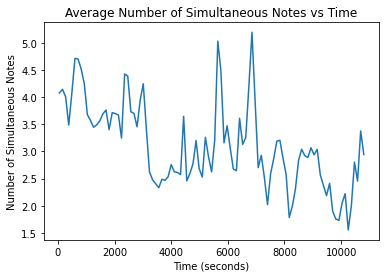

In [31]:
plotSimultaneousForRecord(dataset[0], threshold=0.2, fingers=10)

In [30]:
def plotAllSimultaneous(dataset):
    fig, axs = plt.subplots(2, 3, figsize=(20, 12))
    fig.patch.set_facecolor('white')
    for i, record in enumerate(dataset):
        simultaneous = simultaneousNotes(record)
        x = np.arange(0, len(simultaneous))
        y = [len(i) for i in simultaneous]
        axs[i//3, i%3].scatter(x, y)
        axs[i//3, i%3].set_xlabel("Time [s]]")
        axs[i//3, i%3].set_ylabel("Number of Notes pressed")
        axs[i//3, i%3].set_title("Number of Notes pressed vs Time for record " + str(record["record_id"]))
    plt.show()

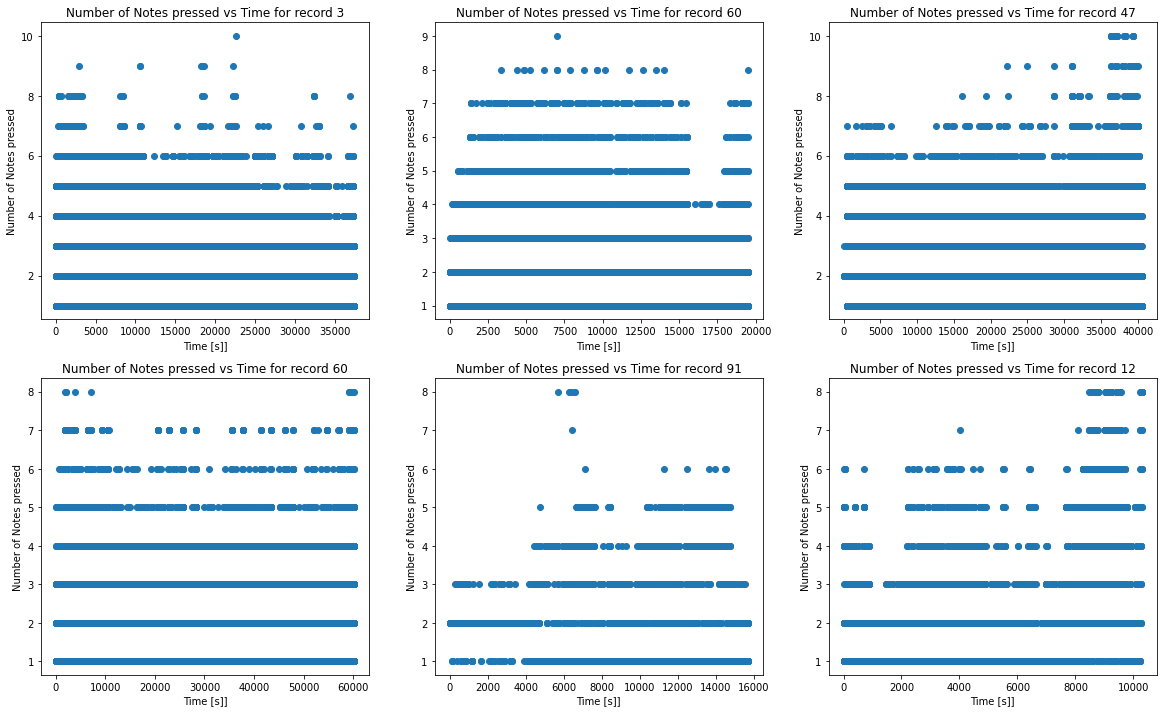

In [31]:
plotAllSimultaneous(dataset)

# Chords


In [15]:
chord_interval = 0.5


In [16]:
def chordDetection(df, chord_interval):
    chords = []
    current_chord = {'start': df.iloc[0]['start'], 'end': df.iloc[0]['end'], 'pitches': [df.iloc[0]['pitch']]}

    for i in range(1, len(df)):
        current_note = df.iloc[i]
        time_difference = current_note['start'] - current_chord['end']
        
        if time_difference <= chord_interval:
            current_chord['end'] = current_note['end']
            current_chord['pitches'].append(current_note['pitch'])
        else:
            # Append the current_chord only if it has more than one note
            if len(current_chord['pitches']) > 1:
                chords.append(current_chord)
            current_chord = {'start': current_note['start'], 'end': current_note['end'], 'pitches': [current_note['pitch']]}

    # Append the last chord only if it has more than one note
    if len(current_chord['pitches']) > 1:
        chords.append(current_chord)

    return pd.DataFrame(chords)

In [17]:
df = pd.DataFrame(dataset[0]["notes"])
chord_interval = 0.05

chords = chordDetection(df, chord_interval)
chords.head(10)

,start,end,pitches
0,1.934219,2.044531,"[42.0, 66.0, 30.0]"
1,2.556146,2.639687,"[49.0, 54.0, 57.0]"
2,2.696875,2.775677,"[54.0, 49.0, 57.0]"
3,2.835521,2.918854,"[54.0, 49.0, 57.0, 45.0]"
4,4.378125,4.920937,"[30.0, 42.0, 66.0, 54.0, 57.0, 49.0]"
5,5.009479,5.084531,"[49.0, 57.0, 54.0]"
6,5.183490,5.251667,"[57.0, 45.0, 54.0]"
7,5.539479,5.992708,"[54.0, 56.0, 47.0, 64.0, 62.0, 59.0, 61.0, 49...."
8,6.314167,6.385625,"[63.0, 49.0, 37.0]"
9,6.524063,8.376875,"[65.0, 30.0, 42.0, 65.0, 66.0, 49.0, 68.0, 57...."


In [18]:
def plot_chords_vs_time(df_chords):
    binSize, unit = binSize_unit(record)

    bins = range(df_chords["start"].min().astype(int), df_chords["end"].max().astype(int), binSize)
    chords = df_chords.groupby(pd.cut(df_chords["start"], bins=bins))["end"].count().reset_index(name="count")

    chords.start = np.arange(1, len(chords) + 1)
    chords.columns = [unit, "chords"]

    plt.plot(chords[unit], chords["chords"])
    ## add background color to the figure

    
    plt.xlabel(unit)
    plt.ylabel("Chords per Minute")
    plt.title("Chords vs Time")
    plt.show()
    

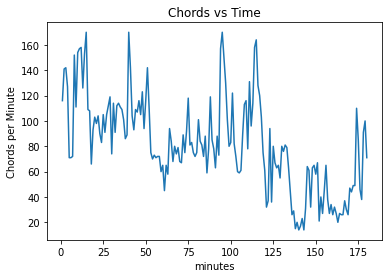

In [19]:
plot_chords_vs_time(chords)

In [20]:
#uncomment to see all records

# for record in dataset:
#     df = pd.DataFrame(record["notes"])
#     chords = chordDetection(df, chord_interval)
#     plot_chords_vs_time(chords)

In [21]:
# display grouped table of chords sorted by count
def chord_count(df_chords):
    #transfer list to tuple
    df_chords['pitches'] = df_chords['pitches'].apply(tuple)
    # remove chords with less than 3 notes
    df_chords = df_chords[df_chords['pitches'].map(len) > 2]
    # return pitches, count table sorted by count
    return df_chords.groupby('pitches').size().reset_index(name='count').sort_values(by='count', ascending=False)

In [22]:
# display grouped table of chords sorted by count

sorted_chords = chord_count(chords)
display(sorted_chords)

,pitches,count
1664,"(50.0, 62.0, 53.0, 65.0, 64.0, 52.0, 60.0, 48....",129
286,"(33.0, 45.0, 57.0, 69.0)",66
1789,"(51.0, 63.0, 54.0, 66.0, 64.0, 52.0, 61.0, 49....",62
298,"(33.0, 45.0, 69.0, 57.0)",59
1422,"(48.0, 60.0, 52.0, 64.0, 62.0, 50.0, 59.0, 47....",58
...,...,...
2496,"(56.0, 51.0, 60.0, 75.0, 63.0)",1
2495,"(56.0, 49.0, 78.0, 59.0, 66.0)",1
2494,"(56.0, 49.0, 66.0, 59.0, 78.0)",1
2492,"(56.0, 49.0, 59.0, 66.0, 78.0)",1


In [23]:
# Using solutions you developed, review this dataset: https://huggingface.co/datasets/roszcz/maestro-v1, and find:

# A piece with the fastest 15 seconds of music
# A piece where a single chord is repeated the most (each piece will have a different chord)

In [24]:
test_dataset = load_dataset("roszcz/maestro-v1", split="train")

Found cached dataset parquet (C:/Users/samue/.cache/huggingface/datasets/roszcz___parquet/roszcz--maestro-v1-b8e6dde91a93bd23/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [25]:
test_dataset

Dataset({
    features: ['notes', 'control_changes', 'composer', 'title', 'year', 'midi_filename'],
    num_rows: 962
})

In [26]:
# a piece with the fastest 15 seconds of music
def fastest_15_seconds(record):
    notes, unit, binSize = binned_number_of_notes(record, binSizeOverride=15)
    return notes["notes"].max()
    

In [27]:
mostNotes = 0
for record in test_dataset:
    notes = fastest_15_seconds(record)
    if notes > mostNotes:
        mostNotes = notes
        fastestRecord = record

print("Fastest 15 seconds of music is", mostNotes, "notes long")
print("In piece: " + record["composer"] + " - " + record["title"] + "(" + str(record["year"]) + ")")

KeyboardInterrupt: 

In [ ]:

idx = None
mostCommonChord = 0

for i in range(len(test_dataset)):
    record = test_dataset[i]
    df = pd.DataFrame(record["notes"])
    chords = chordDetection(df, chord_interval)
    sorted_chords = chord_count(chords)
    if sorted_chords.iloc[0]["count"] > mostCommonChord:
        idx = (record["composer"] + " - " + record["title"] + " (" + str(record["year"]) + ")")
        mostCommonChord = sorted_chords.iloc[0]["count"]
        chord = sorted_chords.iloc[0]["pitches"]

print(f"{idx} with most common chord {chord} repeated {mostCommonChord} times")

Modest Mussorgsky - Pictures at an E(2006) with most common chord (55.0, 43.0, 31.0) repeated 38 times
